In [11]:
# General libraries
import numpy as np
import pandas as pd
import os
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Bayesian Optimization
from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")

In [12]:
path = r'C:\Users\harkn\OneDrive\Desktop\Tasks\Machine Learning in Python\Achievement 2\Project Data'

In [13]:
# Load datasets
df_weather = pd.read_csv(os.path.join(path, 'DATASET_weather_clean_1-10.csv'))
df_answers = pd.read_csv(os.path.join(path, 'DATASET_predictions.csv'))

In [14]:
# Drop unnecessary columns
df_answers = df_answers.drop(columns=['DATE'])

In [15]:
# Convert to NumPy arrays
X = np.array(df_weather)
y = np.array(df_answers)

In [16]:
# Ensure y is in the required format
y = np.argmax(y, axis=1)  # Converts one-hot to categorical

In [17]:
# Check shapes
print("X shape:", X.shape)  # Should be (22950, 15, 9)
print("y shape:", y.shape)  # Should be (22950,)

X shape: (22950, 135)
y shape: (22950,)


In [25]:
#reshape
X = X.reshape(-1,15,9)
X

array([[[  7.    ,   0.85  ,   1.018 , ...,   6.5   ,   0.8   ,
          10.9   ],
        [  1.    ,   0.81  ,   1.0195, ...,   3.7   ,  -0.9   ,
           7.9   ],
        [  4.    ,   0.67  ,   1.017 , ...,   2.4   ,  -0.4   ,
           5.1   ],
        ...,
        [  4.    ,   0.73  ,   1.0304, ...,  -5.9   ,  -8.5   ,
          -3.2   ],
        [  5.    ,   0.98  ,   1.0114, ...,   4.2   ,   2.2   ,
           4.9   ],
        [  5.    ,   0.88  ,   1.0003, ...,   8.5   ,   6.    ,
          10.9   ]],

       [[  6.    ,   0.84  ,   1.018 , ...,   6.1   ,   3.3   ,
          10.1   ],
        [  6.    ,   0.84  ,   1.0172, ...,   2.9   ,   2.2   ,
           4.4   ],
        [  4.    ,   0.67  ,   1.017 , ...,   2.3   ,   1.4   ,
           3.1   ],
        ...,
        [  6.    ,   0.97  ,   1.0292, ...,  -9.5   , -10.5   ,
          -8.5   ],
        [  5.    ,   0.62  ,   1.0114, ...,   4.    ,   3.    ,
           5.    ],
        [  7.    ,   0.91  ,   1.0007, ...,   8.

In [27]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]
Unique values in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]


In [31]:
def create_cnn(neurons, kernel_size, dropout_rate, learning_rate, layers):
    model = Sequential()
    model.add(Conv1D(filters=int(neurons), kernel_size=int(kernel_size), activation='relu', input_shape=(15, 9)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(int(layers)):
        model.add(Dense(int(neurons), activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))  # 15 neurons for 15 classes
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [33]:
# Function to evaluate CNN using given hyperparameters
def cnn_evaluate(neurons, kernel_size, dropout_rate, learning_rate, layers):
    model = create_cnn(neurons, kernel_size, dropout_rate, learning_rate, layers)
    es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Define the parameter space
param_space = {
    'neurons': (16, 128),
    'kernel_size': (2, 5),
    'dropout_rate': (0.1, 0.5),
    'learning_rate': (0.0001, 0.01),
    'layers': (1, 3)
}

# Use Bayesian Optimization
optimizer = BayesianOptimization(
    f=cnn_evaluate,
    pbounds=param_space,
    random_state=42,
    verbose=2
)

# Optimize hyperparameters
optimizer.maximize(init_points=10, n_iter=20)
print("Best Parameters:", optimizer.max)

|   iter    |  target   | dropou... | kernel... |  layers   | learni... |  neurons  |
-------------------------------------------------------------------------------------
| 1         | 0.8146    | 0.2498    | 4.852     | 2.464     | 0.006027  | 33.47     |
| 2         | 0.8057    | 0.1624    | 2.174     | 2.732     | 0.006051  | 95.3      |
| 3         | 0.8233    | 0.1082    | 4.91      | 2.665     | 0.002202  | 36.36     |
| 4         | 0.8536    | 0.1734    | 2.913     | 2.05      | 0.004376  | 48.62     |
| 5         | 0.8261    | 0.3447    | 2.418     | 1.584     | 0.003727  | 67.08     |
| 6         | 0.8061    | 0.4141    | 2.599     | 2.028     | 0.005965  | 21.2      |
| 7         | 0.802     | 0.343     | 2.512     | 1.13      | 0.009494  | 124.2     |
| 8         | 0.8022    | 0.4234    | 2.914     | 1.195     | 0.006874  | 65.3      |
| 9         | 0.8279    | 0.1488    | 3.486     | 1.069     | 0.009102  | 44.98     |
| 10        | 0.8237    | 0.365     | 2.935     | 2.04

In [34]:
# Extract best parameters
best_params = optimizer.max['params']

# Train the CNN with the best parameters
model = create_cnn(
    neurons=int(best_params['neurons']),
    kernel_size=int(best_params['kernel_size']),
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate'],
    layers=int(best_params['layers'])
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
459/459 - 7s - 16ms/step - accuracy: 0.7253 - loss: 0.7869 - val_accuracy: 0.7813 - val_loss: 0.6308
Epoch 2/50
459/459 - 3s - 6ms/step - accuracy: 0.7731 - loss: 0.6417 - val_accuracy: 0.7998 - val_loss: 0.5553
Epoch 3/50
459/459 - 3s - 7ms/step - accuracy: 0.7874 - loss: 0.5908 - val_accuracy: 0.7977 - val_loss: 0.5573
Epoch 4/50
459/459 - 3s - 6ms/step - accuracy: 0.7938 - loss: 0.5709 - val_accuracy: 0.8192 - val_loss: 0.5270
Epoch 5/50
459/459 - 3s - 6ms/step - accuracy: 0.8007 - loss: 0.5493 - val_accuracy: 0.8276 - val_loss: 0.4779
Epoch 6/50
459/459 - 6s - 13ms/step - accuracy: 0.8076 - loss: 0.5305 - val_accuracy: 0.8175 - val_loss: 0.4839
Epoch 7/50
459/459 - 3s - 7ms/step - accuracy: 0.8189 - loss: 0.5096 - val_accuracy: 0.8012 - val_loss: 0.5365
Epoch 8/50
459/459 - 3s - 6ms/step - accuracy: 0.8111 - loss: 0.5169 - val_accuracy: 0.8377 - val_loss: 0.4454
Epoch 9/50
459/459 - 5s - 11ms/step - accuracy: 0.8165 - loss: 0.5071 - val_accuracy: 0.7966 - val_loss: 0.555

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      2955
           1       0.95      0.60      0.73       879
           2       0.51      0.57      0.53       162
           3       0.62      0.25      0.36        64
           4       0.17      0.36      0.23        25
           5       0.61      0.28      0.39        67
           6       0.12      0.22      0.15         9
           7       0.50      0.15      0.23        46
           8       0.08      0.14      0.10         7
           9       0.63      0.62      0.63       360
          10       0.00      0.00      0.00         8
          11       0.22      1.00      0.36         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1

    accuracy                           0.82      4590
   macro avg       0.38      0.37      0.33      4590
weighted avg   

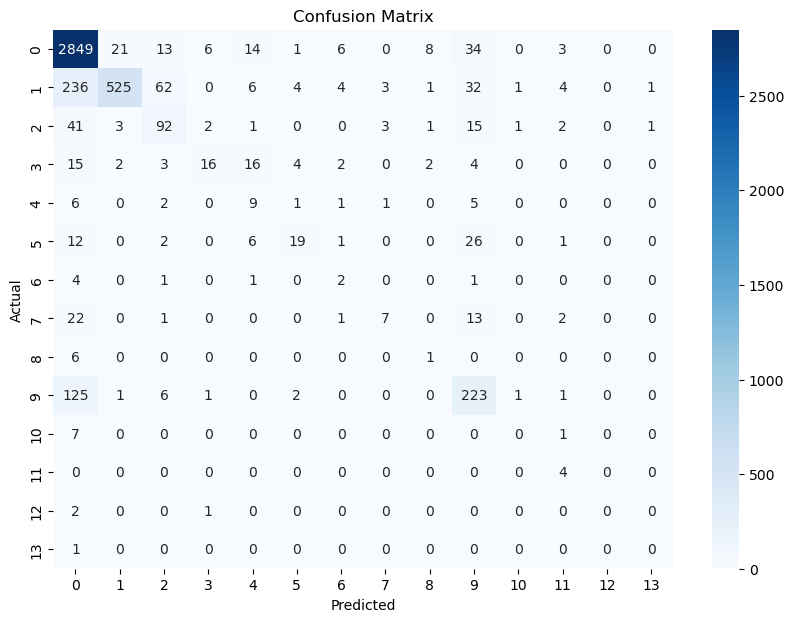

In [35]:
# Evaluate on test data
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Save model
model.save("optimized_cnn_model.h5")

# Save confusion matrix
plt.savefig("confusion_matrix.png")

# Save observations
with open("observations.txt", "w") as f:
    f.write("Optimized CNN Model Observations:\n")
    f.write(f"Best Parameters: {best_params}\n")
    f.write(f"Test Accuracy: {history.history['accuracy'][-1]}\n")
    f.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")

<Figure size 640x480 with 0 Axes>